In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
BS = 32
img_height = 224
img_width = 224

INIT_LR = 0.0001

SEED = 42

In [ ]:
efficientnetb0_base03_dir = "/content/drive/My Drive/models/EfficientNetB0-base03/"
test_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/test"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)

In [ ]:
test_ds = test_datagen.flow_from_directory(
  directory = test_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  shuffle=False,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)

## Load

In [ ]:
test_ds.class_indices

{'aae-femea': 0,
 'aae-macho': 1,
 'aal-femea': 2,
 'aal-macho': 3,
 'cq-femea': 4,
 'cq-macho': 5}

In [ ]:
target_names = []

for key in test_ds.class_indices:

    target_names.append(key)



print(target_names)

['aae-femea', 'aae-macho', 'aal-femea', 'aal-macho', 'cq-femea', 'cq-macho']


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open(efficientnetb0_base03_dir+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(efficientnetb0_base03_dir+"model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss = loss_fn, optimizer = opt, metrics=['accuracy'])
score = loaded_model.evaluate(x = test_ds)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

print("[INFO] Loss: ",score[0])

26/26 [==============================] - 501s 20s/step - loss: 0.2241 - accuracy: 0.9436
accuracy: 94.36%
[INFO] Loss:  0.22414223849773407


In [ ]:
import time
inicio = time.process_time()

predictions = loaded_model.predict(test_ds)
y_pred = predictions.argmax(axis=1)

fim = time.process_time()
tempo = fim - inicio

In [ ]:
tempo

9.427016323

In [ ]:
print(classification_report(test_ds.classes,
                            y_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

   aae-femea       0.95      0.98      0.97       150
   aae-macho       0.88      0.92      0.90       150
   aal-femea       0.94      0.98      0.96       104
   aal-macho       0.93      0.79      0.85       111
    cq-femea       0.97      0.99      0.98       150
    cq-macho       0.99      0.97      0.98       150

    accuracy                           0.94       815
   macro avg       0.94      0.94      0.94       815
weighted avg       0.94      0.94      0.94       815



Confusion matrix, without normalization


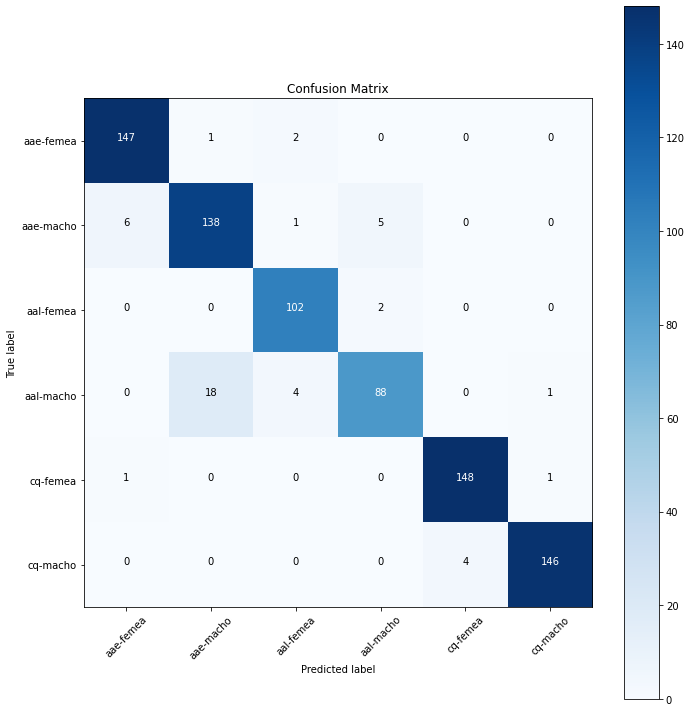

In [ ]:
cm = confusion_matrix(test_ds.classes,
                            y_pred,)

plot_confusion_matrix(cm, target_names, False, title='Confusion Matrix')

In [ ]:
predictions

array([[1.00000000e+00, 1.37810024e-14, 3.90023942e-08, 3.93936836e-13,
        8.40733723e-22, 7.41273932e-31],
       [9.99775469e-01, 2.22796938e-04, 2.93652363e-07, 1.78314119e-09,
        1.56979377e-06, 1.82919041e-10],
       [9.99554574e-01, 8.66027783e-09, 4.45242564e-04, 1.79043667e-07,
        7.87274239e-12, 6.41930537e-17],
       ...,
       [2.01720747e-13, 4.40137526e-09, 1.75479276e-15, 5.51892126e-12,
        4.48022632e-07, 9.99999523e-01],
       [8.12264267e-27, 2.01194421e-13, 6.72417592e-28, 4.45853478e-14,
        1.52966002e-14, 1.00000000e+00],
       [1.65869055e-11, 1.34290215e-08, 1.15073034e-12, 3.70556814e-11,
        1.99031892e-05, 9.99980092e-01]], dtype=float32)

## Curva ROC

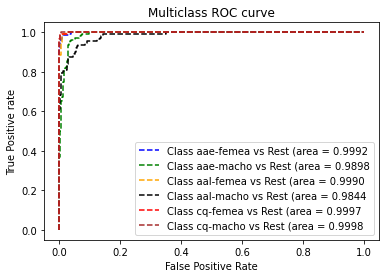

In [ ]:
#ROC CURVE
from sklearn.metrics import roc_curve, auc



# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}
n_class = 6
colors = ['blue','green','orange','black','red','brown']


for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_ds.classes, predictions[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting
for i in range(n_class):
  plt.plot(fpr[i], tpr[i], linestyle='--',color= colors[i], label=f'Class {target_names[i]} vs Rest (area = {roc_auc[i]:0.4f}')
'''plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class aae-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[1]))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class aal-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[2]))
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class aal-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[3]))
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class cq-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[4]))
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class cq-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[5]))'''


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Curva PR

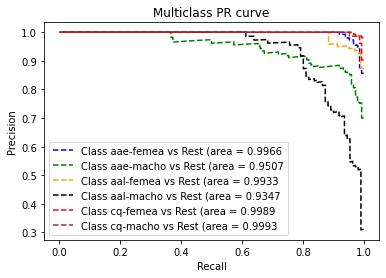

In [ ]:
#ROC CURVE
from sklearn.metrics import precision_recall_curve, auc



# roc curve for classes
precision = {}
recall = {}
thresh ={}
roc_auc = {}
n_class = 6
colors = ['blue','green','orange','black','red','brown']

for i in range(n_class):    
    precision[i], recall[i], thresh[i] = precision_recall_curve(test_ds.classes, predictions[:,i], pos_label=i)
    roc_auc[i] = auc(recall[i],precision[i])
    
# plotting
for i in range(n_class):
  plt.plot(recall[i], precision[i], linestyle='--',color= colors[i], label=f'Class {target_names[i]} vs Rest (area = {roc_auc[i]:0.4f}')    
'''plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class aae-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[0]))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class aae-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[1]))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class aal-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[2]))
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class aal-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[3]))
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class cq-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[4]))
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class cq-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[5]))'''


plt.title('Multiclass PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.savefig('Multiclass PR',dpi=300);